In [1]:
import numpy as np
import pandas as pd

In [52]:
from google.colab import drive
drive.mount('/content/drive')
filepath="/content/drive/MyDrive/Colab Notebooks"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
stock_data = pd.read_csv(f"{filepath}/VCB_stock_data.csv")
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Attributes    1254 non-null   object
 1   code          1253 non-null   object
 2   high          1253 non-null   object
 3   low           1253 non-null   object
 4   open          1253 non-null   object
 5   close         1253 non-null   object
 6   adjust        1253 non-null   object
 7   volume_match  1253 non-null   object
 8   value_match   1253 non-null   object
dtypes: object(9)
memory usage: 88.3+ KB


In [109]:
stock_data.head()

,Attributes,code,high,low,open,close,adjust,volume_match,value_match
0,Symbols,VCB,VCB,VCB,VCB,VCB,VCB,VCB,VCB
1,date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-28,VCB,65.7,64.8,65.5,64.8,64.8,1650600.0,107522000000.0
3,2024-12-31,VCB,92.4,91.2,92.2,91.2,61.0,2374000.0,217412000000.0
4,2024-12-30,VCB,92.5,92.0,92.2,92.0,61.54,1706700.0,157327000000.0


# **Step 1: Data Cleaning + Transformation**


In [110]:
stock_data = stock_data.drop([0, 1,2])  # Xóa dòng 0, 1, 2 và dòng cuối cùng
stock_data.rename(columns={'Attributes': 'date'}, inplace=True)
stock_data.reset_index(drop=True, inplace=True)


In [111]:
# Kiểm tra missing values
missing_values = stock_data.isnull().sum()
print("Missing Values:\n", missing_values)

# Kiểm tra duplicate rows
duplicate_rows = stock_data.duplicated().sum()
if duplicate_rows > 0:
    # Remove duplicate rows
    stock_data.drop_duplicates(inplace=False)
    print(f'Removed {duplicate_rows} duplicate rows')
else:
    print('No duplicate rows found')


# Check for outliers in numerical columns
numerical_summary = stock_data.describe()
print("\nNumerical Summary:\n", numerical_summary)

Missing Values:
 date            0
code            0
high            0
low             0
open            0
close           0
adjust          0
volume_match    0
value_match     0
dtype: int64
No duplicate rows found

Numerical Summary:
               date  code  high   low  open close adjust volume_match  \
count         1251  1251  1251  1251  1251  1251   1251         1251   
unique        1251     1   345   348   342   352    544         1216   
top     2019-12-31   VCB  89.5  92.0  83.0  92.0  61.54    1259500.0   
freq             1  1251    18    18    21    20     14            2   

          value_match  
count            1251  
unique           1244  
top     70793000000.0  
freq                3  


In [112]:
stock_data

,date,code,high,low,open,close,adjust,volume_match,value_match
0,2024-12-31,VCB,92.4,91.2,92.2,91.2,61.0,2374000.0,217412000000.0
1,2024-12-30,VCB,92.5,92.0,92.2,92.0,61.54,1706700.0,157327000000.0
2,2024-12-27,VCB,93.0,92.2,92.5,92.2,61.67,1639900.0,151654000000.0
3,2024-12-26,VCB,92.8,92.0,92.5,92.1,61.61,2202900.0,203219000000.0
4,2024-12-25,VCB,93.8,92.2,92.2,92.4,61.81,1827700.0,169706000000.0
...,...,...,...,...,...,...,...,...,...
1246,2020-01-07,VCB,87.9,85.4,87.0,87.8,38.19,1013270.0,87685000000.0
1247,2020-01-06,VCB,89.5,87.5,89.2,87.5,38.06,880110.0,77925000000.0
1248,2020-01-03,VCB,91.8,89.9,91.5,89.9,39.1,536130.0,48684000000.0
1249,2020-01-02,VCB,91.4,89.7,90.2,90.8,39.49,386290.0,35031000000.0


Kết quả kiểm tra trong bước Data Cleaning:
- Không có giá trị thiếu trong bất kỳ cột nào trừ các ngày làm việc
- Không có dòng trùng lặp trong dữ liệu.
- Các giá trị số có vẻ hợp lý, không xuất hiện bất thường rõ ràng.

In [113]:
# Convert 'date' column to pandas datetime format
stock_data['date'] = pd.to_datetime(stock_data['date'])  # Convert to datetime
stock_data.set_index('date', inplace=True)  # Set as index, so that pandas can handle timeseries
stock_data = stock_data.sort_index()  # Ensure it's sorted

In [114]:
# Fill missing data only for weekdays (Monday to Friday)
stock_data_filled = stock_data.asfreq('B').copy()  # asfreq('B') auto keep business day and fill missing data, remove duplicate day

# Fill missing values (which includes holidays) with the previous valid value
stock_data_filled = stock_data_filled.fillna(method='ffill')

print("\nFilled dataframe (only business days, with holidays filled):")
print(stock_data_filled.head())

# Display the full filled dataframe
stock_data_filled


Filled dataframe (only business days, with holidays filled):
           code  high   low  open close adjust volume_match    value_match
date                                                                      
2019-12-31  VCB  91.1  90.1  90.6  90.2  39.23     230770.0  20885000000.0
2020-01-01  VCB  91.1  90.1  90.6  90.2  39.23     230770.0  20885000000.0
2020-01-02  VCB  91.4  89.7  90.2  90.8  39.49     386290.0  35031000000.0
2020-01-03  VCB  91.8  89.9  91.5  89.9   39.1     536130.0  48684000000.0
2020-01-06  VCB  89.5  87.5  89.2  87.5  38.06     880110.0  77925000000.0


<ipython-input-114-be88481e95ee>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data_filled = stock_data_filled.fillna(method='ffill')


,code,high,low,open,close,adjust,volume_match,value_match
date,,,,,,,,
2019-12-31,VCB,91.1,90.1,90.6,90.2,39.23,230770.0,20885000000.0
2020-01-01,VCB,91.1,90.1,90.6,90.2,39.23,230770.0,20885000000.0
2020-01-02,VCB,91.4,89.7,90.2,90.8,39.49,386290.0,35031000000.0
2020-01-03,VCB,91.8,89.9,91.5,89.9,39.1,536130.0,48684000000.0
2020-01-06,VCB,89.5,87.5,89.2,87.5,38.06,880110.0,77925000000.0
...,...,...,...,...,...,...,...,...
2024-12-25,VCB,93.8,92.2,92.2,92.4,61.81,1827700.0,169706000000.0
2024-12-26,VCB,92.8,92.0,92.5,92.1,61.61,2202900.0,203219000000.0
2024-12-27,VCB,93.0,92.2,92.5,92.2,61.67,1639900.0,151654000000.0


In [115]:
# Lưu lại giá trị của ngày 01-01-2020 trước khi xóa
backup_row = stock_data_filled.loc['2020-01-01'].copy()

# Xóa ngày 31-12-2019
stock_data_filled = stock_data_filled.drop(index='2019-12-31')

# Khôi phục ngày 01-01-2020 nếu nó bị mất do ffill trước đó
if '2020-01-01' not in stock_data_filled.index:
    stock_data_filled.loc['2020-01-01'] = backup_row

# Sort lại index để đảm bảo thứ tự đúng
stock_data_filled = stock_data_filled.sort_index()
stock_data_filled

,code,high,low,open,close,adjust,volume_match,value_match
date,,,,,,,,
2020-01-01,VCB,91.1,90.1,90.6,90.2,39.23,230770.0,20885000000.0
2020-01-02,VCB,91.4,89.7,90.2,90.8,39.49,386290.0,35031000000.0
2020-01-03,VCB,91.8,89.9,91.5,89.9,39.1,536130.0,48684000000.0
2020-01-06,VCB,89.5,87.5,89.2,87.5,38.06,880110.0,77925000000.0
2020-01-07,VCB,87.9,85.4,87.0,87.8,38.19,1013270.0,87685000000.0
...,...,...,...,...,...,...,...,...
2024-12-25,VCB,93.8,92.2,92.2,92.4,61.81,1827700.0,169706000000.0
2024-12-26,VCB,92.8,92.0,92.5,92.1,61.61,2202900.0,203219000000.0
2024-12-27,VCB,93.0,92.2,92.5,92.2,61.67,1639900.0,151654000000.0


# **Dimensionality Reduction**



In [116]:
# Bỏ các cột không liên quan trực tiếp đến dự đoán giá cổ phiếu
columns_to_drop = ['code', 'adjust', 'value_match']
stock_data_reduced = stock_data_filled.drop(columns=columns_to_drop, axis=1)

stock_data_reduced.head()

,high,low,open,close,volume_match
date,,,,,
2020-01-01,91.1,90.1,90.6,90.2,230770.0
2020-01-02,91.4,89.7,90.2,90.8,386290.0
2020-01-03,91.8,89.9,91.5,89.9,536130.0
2020-01-06,89.5,87.5,89.2,87.5,880110.0
2020-01-07,87.9,85.4,87.0,87.8,1013270.0


In [117]:
from google.colab import files
# Save the filled dataframe to a CSV file

stock_data_reduced.to_csv('Stock_VCB_filled.csv')

# Download the filled CSV file
files.download('Stock_VCB_filled.csv') # Use files.download instead of stock_data_reduced.download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Feature Selection**

Correlation Matrix:
                  high       low      open     close  volume_match
high          1.000000  0.989840  0.992355  0.995010      0.137428
low           0.989840  1.000000  0.993971  0.992145      0.079941
open          0.992355  0.993971  1.000000  0.989061      0.099298
close         0.995010  0.992145  0.989061  1.000000      0.114623
volume_match  0.137428  0.079941  0.099298  0.114623      1.000000


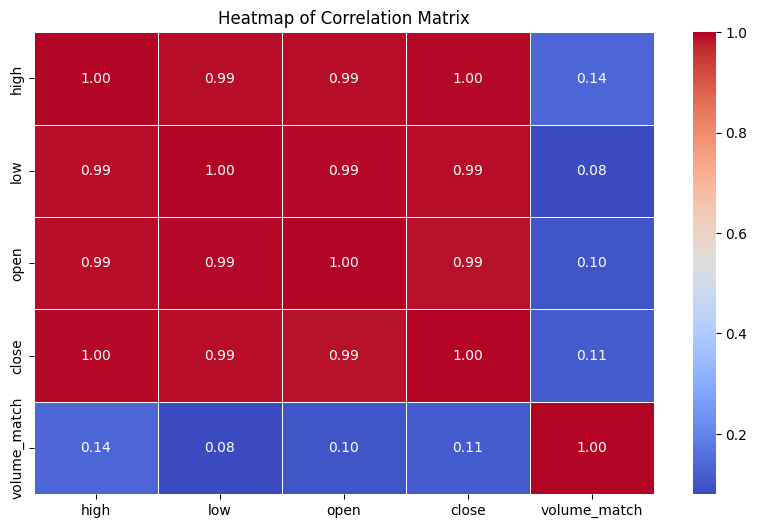

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu
file_path = "/content/Stock_VCB_filled.csv"
df = pd.read_csv(file_path)

# Chuyển đổi cột 'date' sang định dạng datetime
df['date'] = pd.to_datetime(df['date'])

# Lọc dữ liệu trong khoảng thời gian từ 01/01/2020 đến 31/12/2024
df_filtered = df[(df['date'] >= "2020-01-01") & (df['date'] <= "2024-12-31")]

# Loại bỏ cột 'date' nếu không cần thiết trong phân tích tương quan
df_filtered = df_filtered.drop(columns=['date'])

# Tính ma trận tương quan
corr_matrix = df_filtered.corr()

# Hiển thị ma trận tương quan
print("Correlation Matrix:")
print(corr_matrix)

# Vẽ heatmap trực quan hóa ma trận tương quan
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Correlation Matrix")
plt.show()


In [100]:
df_filtered

,date,high,low,open,close,volume_match
1,2020-01-01,91.1,90.1,90.6,90.2,230770.0
2,2020-01-02,91.4,89.7,90.2,90.8,386290.0
3,2020-01-03,91.8,89.9,91.5,89.9,536130.0
4,2020-01-06,89.5,87.5,89.2,87.5,880110.0
5,2020-01-07,87.9,85.4,87.0,87.8,1013270.0
...,...,...,...,...,...,...
1301,2024-12-25,93.8,92.2,92.2,92.4,1827700.0
1302,2024-12-26,92.8,92.0,92.5,92.1,2202900.0
1303,2024-12-27,93.0,92.2,92.5,92.2,1639900.0
1304,2024-12-30,92.5,92.0,92.2,92.0,1706700.0


Thống kê mô tả dữ liệu

In [101]:
summary_statistics = df_filtered.describe()
summary_statistics

,date,high,low,open,close,volume_match
count,1305,1305.000000,1305.000000,1305.000000,1305.000000,1.305000e+03
mean,2022-07-01 19:12:00,89.552644,87.593946,88.578084,88.603678,1.267887e+06
min,2020-01-01 00:00:00,58.400000,56.600000,57.200000,57.200000,2.257000e+05
25%,2021-04-01 00:00:00,83.700000,82.300000,83.000000,83.000000,8.177700e+05
50%,2022-07-01 00:00:00,90.000000,88.500000,89.200000,89.300000,1.146400e+06
75%,2023-10-02 00:00:00,95.800000,93.500000,94.600000,94.500000,1.575400e+06
max,2024-12-31 00:00:00,117.200000,115.000000,116.700000,116.400000,6.274200e+06
std,NaN,9.112222,9.021470,9.085902,9.091940,6.567688e+05


1/ Dữ liệu: Bộ dữ liệu chứa thông tin giá cổ phiếu theo thời gian, bao gồm khoảng thời gian từ ngày 2019-10-01 đến 2024-09-30. Dữ liệu bao gồm một khoảng thời gian liên tục với các phiên giao dịch trong tuần (từ Thứ Hai đến Thứ Sáu), ngoại trừ các ngày cuối tuần và ngày lễ khi thị trường chứng khoán đóng cửa. Dữ liệu bao gồm các thông tin sau:
- Ngày giao dịch (Date): Ngày diễn ra giao dịch.
- Giá cao nhất, thấp nhất, mở cửa, và đóng cửa (High, Low, Open, Close Prices): Giá cổ phiếu hàng ngày, bao gồm giá cao nhất, thấp nhất, giá mở cửa và giá đóng cửa.
Khối lượng giao dịch khớp lệnh (Volume Match): Tổng khối lượng giao dịch khớp lệnh trong ngày.

.....

2/ Thách thức: Bộ dữ liệu không cung cấp thêm bối cảnh bổ sung như các chỉ số kinh tế vĩ mô, tin tức ngành, hoặc các sự kiện cấp công ty có thể ảnh hưởng đến giá cổ phiếu. Ngoài ra, việc xử lý các ngày nghỉ giao dịch do cuối tuần hoặc ngày lễ cần được xử lý cẩn thận trong quá trình phân tích.

3/ Tiền xử lý dữ liệu:
- Loại bỏ các ngày giao dịch trùng lặp (nếu có).
- Loại bỏ các ngày giao dịch có dữ liệu thiếu (nếu có).
- Liệt kê các ngày cuối tuần và ngày lễ không có giao dịch bị thiếu trong bộ dữ liệu.
- Đảm bảo tất cả dữ liệu số được định dạng và chuẩn hóa đúng cách để phục vụ phân tích tiếp theo.

4/Các biến dùng để phân tích: Các biến sau đã được tiền xử lý và sẵn sàng cho việc xây dựng mô hình dự đoán hoặc phân tích:
- Ngày giao dịch (Date): Dùng để sắp xếp theo thời gian và phân tích chuỗi thời gian.
- Giá cao nhất, thấp nhất, mở cửa, và đóng cửa (High, Low, Open, Close Prices): Các yếu tố cơ bản để phát hiện xu hướng và mô hình giá.
- Khối lượng giao dịch và giá trị giao dịch (Volume Match): Các chỉ báo về hoạt động và thanh khoản của thị trường.
